In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

# load the Data

In [3]:
train = pd.read_csv(r'datasets\train.csv')
test = pd.read_csv(r'datasets\test.csv')
sample_submission = pd.read_csv(r'datasets\sample_submission.csv')


# EDA

In [4]:
print(train.head())

   id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2       0.06           35  daylight   rainy   
1   1     urban          4       0.99           35  daylight   clear   
2   2     rural          4       0.63           70       dim   clear   
3   3   highway          4       0.07           35       dim   rainy   
4   4     rural          1       0.58           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1           0.13  
1                       0           

In [5]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [6]:
print(train.isnull().sum())

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


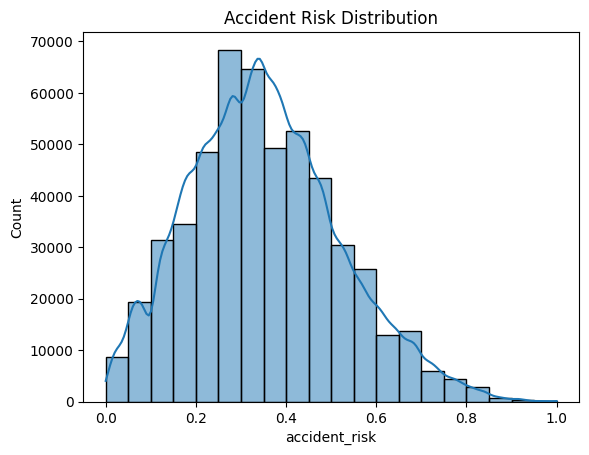

In [7]:
sns.histplot(train['accident_risk'], bins=20, kde=True)
plt.title('Accident Risk Distribution')
plt.show()

# Feature Engineering

In [8]:
categorical_features = ['road_type', 'weather', 'time_of_day']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat = pd.DataFrame(encoder.fit_transform(train[categorical_features]), columns=encoder.get_feature_names_out())
X_test_cat = pd.DataFrame(encoder.transform(test[categorical_features]), columns=encoder.get_feature_names_out())

# Merge one-hot with numeric

In [9]:
numeric_features = [col for col in train.columns if col not in categorical_features + ['id', 'accident_risk']]
X_num = train[numeric_features].reset_index(drop=True)
X_test_num = test[numeric_features].reset_index(drop=True)

In [10]:
X = pd.concat([X_num, X_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)
y = train['accident_risk']

# 5. Modeling & Cross-Validation

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_predictions = np.zeros(len(X))
test_predictions = np.zeros(len(X_test))

In [16]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    # create copies to avoid SettingWithCopyWarning
    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Ensure any remaining object/category columns are numeric and aligned between train/val/test
    obj_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    for c in obj_cols:
        # build categories from combined train+test to keep mappings consistent
        combined = pd.Categorical(pd.concat([X_train[c], X_test[c]], axis=0))
        X_train[c] = pd.Categorical(X_train[c], categories=combined.categories).codes
        X_val[c] = pd.Categorical(X_val[c], categories=combined.categories).codes
        X_test[c] = pd.Categorical(X_test[c], categories=combined.categories).codes

    # optional debug output (keeps types/numeric conversion visible)
    if obj_cols:
        print("Object/category columns converted to codes:", obj_cols)
        for c in obj_cols:
            print(f"  {c} -> train unique codes: {pd.Series(X_train[c].unique())[:10].tolist()}")

    # train and predict
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    oof_predictions[val_idx] = model.predict(X_val)
    test_predictions += model.predict(X_test) / kf.n_splits

    # mean_squared_error in some sklearn versions does not accept `squared` argument.
    # compute RMSE explicitly to avoid TypeError.
    rmse = np.sqrt(mean_squared_error(y_val, oof_predictions[val_idx]))
    print(f'Fold {fold+1} RMSE:', rmse)

Object/category columns converted to codes: ['lighting']
  lighting -> train unique codes: [3, 4, 5]


KeyboardInterrupt: 

# FEATURE IMPORTANCE

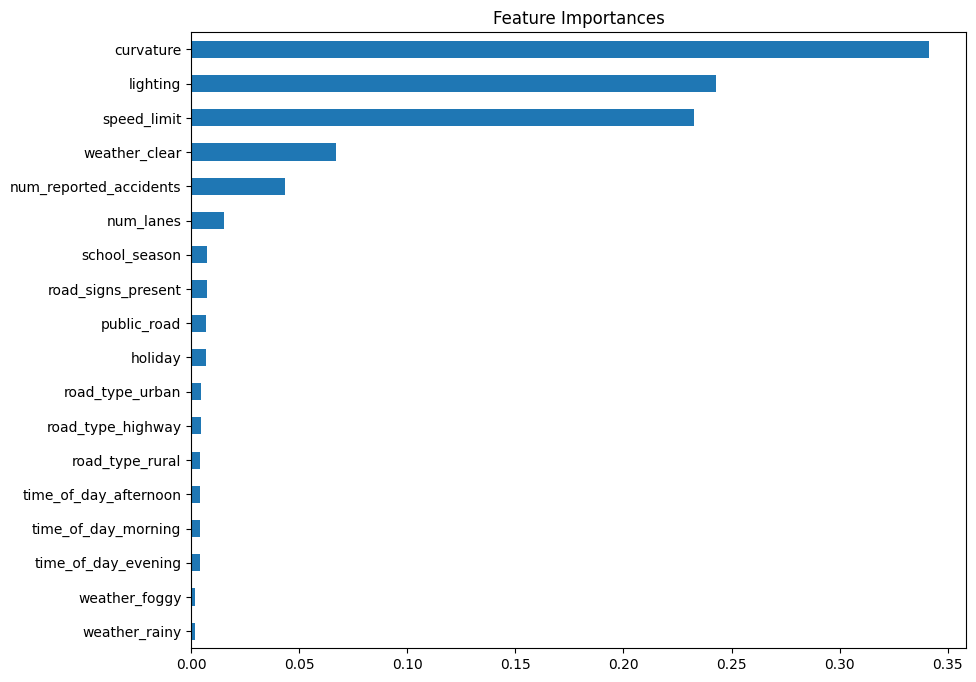

In [ ]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(10,8))
plt.title('Feature Importances')
plt.show()

# ERROR ANALYSIS BY ROAD TYPE

In [ ]:
preds_val_df = train[['road_type']].copy()
preds_val_df['pred'] = oof
preds_val_df['actual'] = y
preds_val_df['sq_error'] = (preds_val_df['pred'] - preds_val_df['actual'])**2

rmse_by_road = preds_val_df.groupby('road_type')['sq_error'].mean().apply(np.sqrt)
rmse_by_road.plot(kind='bar', figsize=(8,5), title='RMSE by Road Type')
plt.ylabel('RMSE')
plt.show()

# Also show RMSE values
print("\nRMSE by Road Type:")
print(rmse_by_road.sort_values(ascending=False))

# Show mean accident risk by road type
mean_risk_by_road = preds_val_df.groupby('road_type')['actual'].mean()
print("\nMean Accident Risk by Road Type:")
print(mean_risk_by_road.sort_values(ascending=False))

# Distribution analysis
print("\nRoad Type Distribution:")
print(train['road_type'].value_counts())

NameError: name 'oof' is not defined

# Overall RMSE

In [ ]:
import numpy as np

# Calculate MSE, then take square root to get RMSE
score = np.sqrt(mean_squared_error(y, oof_predictions))
print(f'Overall RMSE: {score}')
rmse = np.sqrt(mean_squared_error(y_val, oof_predictions[val_idx]))
print(f'Fold {fold+1} RMSE:', rmse)


TypeError: got an unexpected keyword argument 'squared'

# Submission

submission = sample_submission.copy()
submission['accident_risk'] = np.clip(test_predictions, 0, 1)  # Clip predictions to 0-1 range
submission.to_csv('submission.csv', index=False)
print('Submission file saved!')